In [14]:
import pandas as pd
import time 
import json
import urllib.request
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from pandas.io.json import json_normalize
from joblib import Parallel, delayed
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error

## Importing RPi JSON Data to DataFrame

In [3]:
df = pd.read_json("https://alte-rs.ddnss.de/weather/processed/history.json")
df['time'] = pd.to_datetime(df['time'])
df['temp'] = pd.to_numeric(df['temp'])
df['pressure'] = pd.to_numeric(df['pressure'])
df['humidity'] = pd.to_numeric(df['humidity'])
dataframe_rpi = df.set_index('time')
print(dataframe_rpi.shape)
dataframe_rpi.head()

(38012, 3)


,humidity,pressure,temp
time,,,
2018-06-22 16:20:01.656,36.116451,1025.179932,28.907051
2018-06-22 16:20:40.606,35.238693,1025.148682,28.870728
2018-06-22 16:21:19.756,35.684219,1025.106445,28.852566
2018-06-22 16:21:58.636,35.843815,1025.139404,28.907051
2018-06-22 16:22:37.505,36.053280,1025.058105,28.870728


## Smoothing RPi Data

### Rolling Sums

(36099, 3)
humidity    3
pressure    3
temp        3
dtype: int64
                          humidity     pressure       temp
time                                                      
2018-06-22 16:20:01.656        NaN          NaN        NaN
2018-06-22 16:20:40.606  35.677572  1025.164307  28.888889
2018-06-22 16:21:19.756  35.679788  1025.145020  28.876781
2018-06-22 16:21:58.636  35.720795  1025.143616  28.884349
2018-06-22 16:22:37.505  35.787292  1025.126514  28.881625


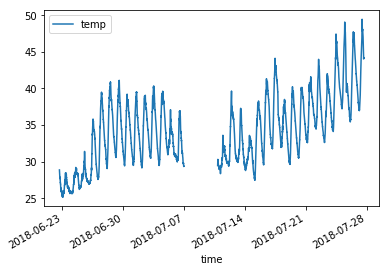

In [3]:
window_length='10min'
min_data_points=2
dataframe_rpi_rolling = dataframe_rpi.rolling(window=window_length,min_periods=min_data_points).mean()


print(dataframe_rpi_rolling.shape)
print(dataframe_rpi_rolling.isnull().sum())
print(dataframe_rpi_rolling.head())
dataframe_rpi_rolling.plot(y='temp')

### Resampling

(26506, 3)
humidity    0
pressure    0
temp        0
dtype: int64
                      humidity     pressure       temp
time                                                  
2018-06-22 16:20:00  36.116451  1025.179932  28.907051
2018-06-22 16:22:00  36.053280  1025.058105  28.870728
2018-06-22 16:24:00  35.697521  1025.116943  28.943377
2018-06-22 16:26:00  35.335114  1025.070068  28.943377
2018-06-22 16:28:00  36.714924  1025.146240  28.798077


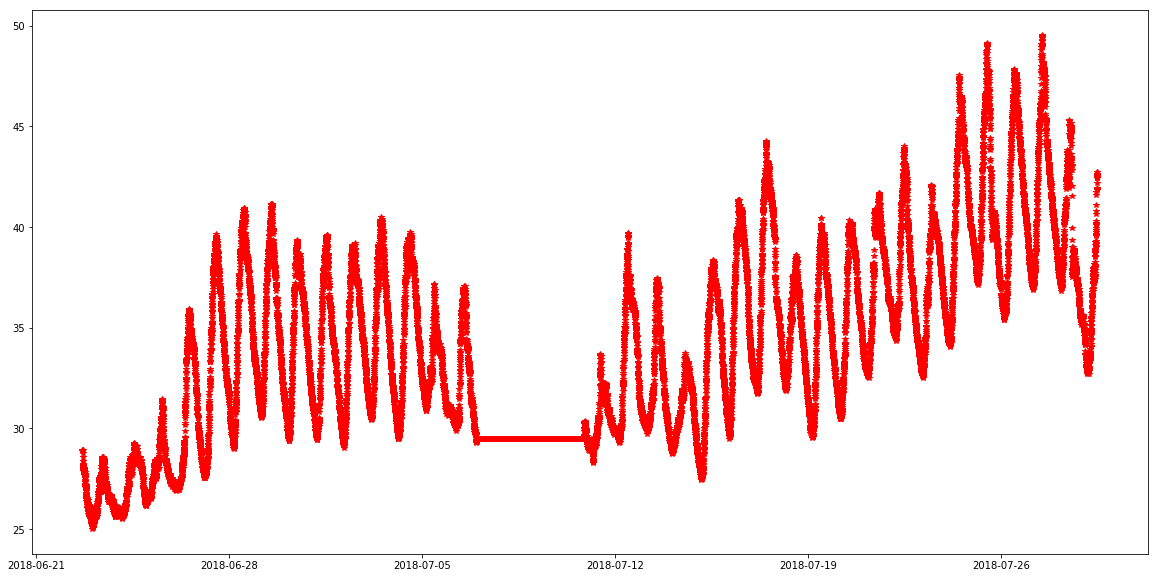

In [4]:
dataframe_rpi_resampled = dataframe_rpi.resample('2min').bfill()

print(dataframe_rpi_resampled.shape)
print(dataframe_rpi_resampled.isnull().sum())
print(dataframe_rpi_resampled.head())
plt.figure(figsize=(20,10))
plt.plot(dataframe_rpi_resampled['temp'],'r*')

## Importing OWM Data

In [5]:
with urllib.request.urlopen("https://alte-rs.ddnss.de/weather/processed/history_owm.json") as url:
    data = json.loads(url.read().decode())
init_table = json_normalize(data)
weather_descr = json_normalize(data,record_path=['weather'],record_prefix='weather.')
temp = init_table.join(weather_descr)
temp['time'] = pd.to_datetime(temp['dt'],unit='s')
temp['temp'] = pd.to_numeric(temp['main.temp'])-273.15
temp['humidity'] = pd.to_numeric(temp['main.humidity'])
temp['pressure'] = pd.to_numeric(temp['main.pressure'])
dataframe_owm = temp.set_index('time')
dataframe_owm_resampled = dataframe_owm[['temp','pressure','humidity']].resample('30min').mean()
dataframe_owm_resampled.head()

,temp,pressure,humidity
time,,,
2018-06-16 20:30:00,17.509474,1013.0,77.0
2018-06-16 21:00:00,18.010000,1013.0,77.0
2018-06-16 21:30:00,18.010000,1013.0,77.0
2018-06-16 22:00:00,17.506667,1013.0,77.0
2018-06-16 22:30:00,17.000000,1013.0,82.0


## Creating Feature Matrix and Prediction Vector

### Reducing the input values to a maxmimum of one row every 5min

In [6]:
#time_step = timedelta(minutes = 5)
#init = dataframe_rpi_rolling.index[0]

#for time in dataframe_rpi_rolling.index:
#    if time-init > time_step:
#        init = time
#    else:
#        dataframe_rpi_rolling = dataframe_rpi_rolling.drop(time)
#dataframe_rpi_rolling.head()

### Creating prediction matrix y 

In [5]:
dataframe_input=dataframe_rpi_resampled
# dataframe_input = dataframe_rpi_rolling

# predicting the next 120 minutes
prediction_steps = 60
history_steps = 10

y = dataframe_input[ prediction_steps + history_steps :]
y_index = dataframe_input[ prediction_steps + history_steps :].index

length = len(y)
print(y.shape)
print(np.isnan(y).sum())

(26436, 3)
humidity    0
pressure    0
temp        0
dtype: int64


### Creating input matrix x, which contains history_steps consequtive historical values (time steps)

In [6]:
x = np.empty((length, 3*history_steps))


def xrow (start):
    return dataframe_input[ start : start + history_steps ].values.flatten();


for n in  range(0,length):
    x[n] =xrow(n)
print(x.shape)
print(np.isnan(x).sum())

(26436, 30)
0


## Using Imputer to get rid of NaNs


In [7]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(x)
x_imputer = imputer.transform(x)
imputer = imputer.fit(y)
y_imputer = pd.DataFrame(data=imputer.transform(y), columns=['humidity','pressure','temp'], index=y_index)

y_imputer.shape


(26436, 3)

## Scaling the features and splitting up into training and testing

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# x_train_sc = scaler.fit_transform(x_train)
# x_test_sc = scaler.fit_transform(x_test)
x_scaled = scaler.fit_transform(x_imputer)


cut=len(y_imputer)*4//5 # First part of data is for training, the other testing
y_train = y_imputer[0:cut]
x_train = x_scaled[0:cut]
y_test = y_imputer[cut:]
x_test = x_scaled[cut:]

## Learning with linear regression

In [9]:
training_data_input  = x_train
training_data_target = y_train

testing_data_input   = x_test
testing_data_target  = y_test



from sklearn.linear_model import LinearRegression
regressor_temp = LinearRegression(n_jobs=-1)
regressor_temp = regressor_temp.fit(training_data_input, training_data_target['temp'])
sorted_coefs_temp = regressor_temp.coef_.reshape(history_steps,3)
intercept_temp = regressor_temp.intercept_

regressor_hum = LinearRegression(n_jobs=-1)
regressor_hum = regressor_hum.fit(training_data_input, training_data_target['humidity'])
sorted_coefs_hum = regressor_hum.coef_.reshape(history_steps,3)
intercept_hum = regressor_hum.intercept_

regressor_press = LinearRegression(n_jobs=-1)
regressor_press = regressor_press.fit(training_data_input, training_data_target['pressure'])
sorted_coefs_hum = regressor_press.coef_.reshape(history_steps,3)
intercept_hum = regressor_press.intercept_

training_result = pd.DataFrame(data={'temp' : regressor_temp.predict(training_data_input),'pressure' : regressor_press.predict(training_data_input), 'humidity' : regressor_hum.predict(training_data_input)}, index=y_train.index)
testing_result  = pd.DataFrame(data={'temp' : regressor_temp.predict(testing_data_input),'pressure' : regressor_press.predict(testing_data_input), 'humidity' : regressor_hum.predict(testing_data_input)}, index=y_test.index)

## Gathering Statistics

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     6305.
Date:                Sun, 29 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:41:17   Log-Likelihood:                -34835.
No. Observations:               21148   AIC:                         6.973e+04
Df Residuals:                   21117   BIC:                         6.998e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.9241      0.010   3402.606      0.0

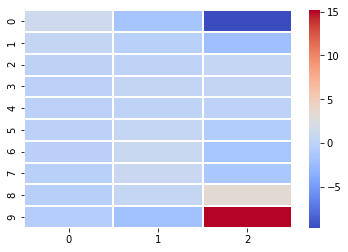

In [25]:
training_data_const = sm.add_constant(training_data_input)
linear_model = sm.OLS(training_data_target['temp'], training_data_const)
insample_stats = linear_model.fit()
testing_data_const = sm.add_constant(testing_data_input)
outsample_stats = insample_stats.predict(testing_data_const)

sn.heatmap(sorted_coefs_temp,cmap='coolwarm',linewidths=1)

print(insample_stats.summary())
#print(outsample_stats.summary())


### Interpreting the statistics

Question - Is there a relationship at all between the response and predictors?
Answer - F statistic
Here : F value is large (Essentially number of standard deviations of an event when there is no relationship and the results seen are just due to chance) 
       Probability of F value is zero -> There is a linear relationship!
       t-statistic of individual variables (probability that a variable is zero and its
       contribution is produced by chance is low for:
       const, x1, x3, x4, x6, x21, x22,x24,x25,x27,x28,x29,x30
       However, number of variables is large, so that some of them are probably due to chance
       R^2 is close to 1 and explains how much of the variablitiy of the response can
       be explained by the model.
       

Mean squared errors on train and test


In [22]:
for column in training_data_target.columns:
    err = mean_squared_error(training_data_target[column],training_result[column])
    print('Error in ' + column, err)

Error in humidity 6.771357201376258
Error in pressure 0.16622464789564192
Error in temp 1.5785108645699553


In [23]:
for column in training_data_target.columns:
    err = mean_squared_error(testing_data_target[column],testing_result[column])
    print('Error in ' + column, err)

Error in humidity 12.27390943637758
Error in pressure 0.47157260937504025
Error in temp 3.5932904563171104




## In-Sample and Out-Of-Sample Plots

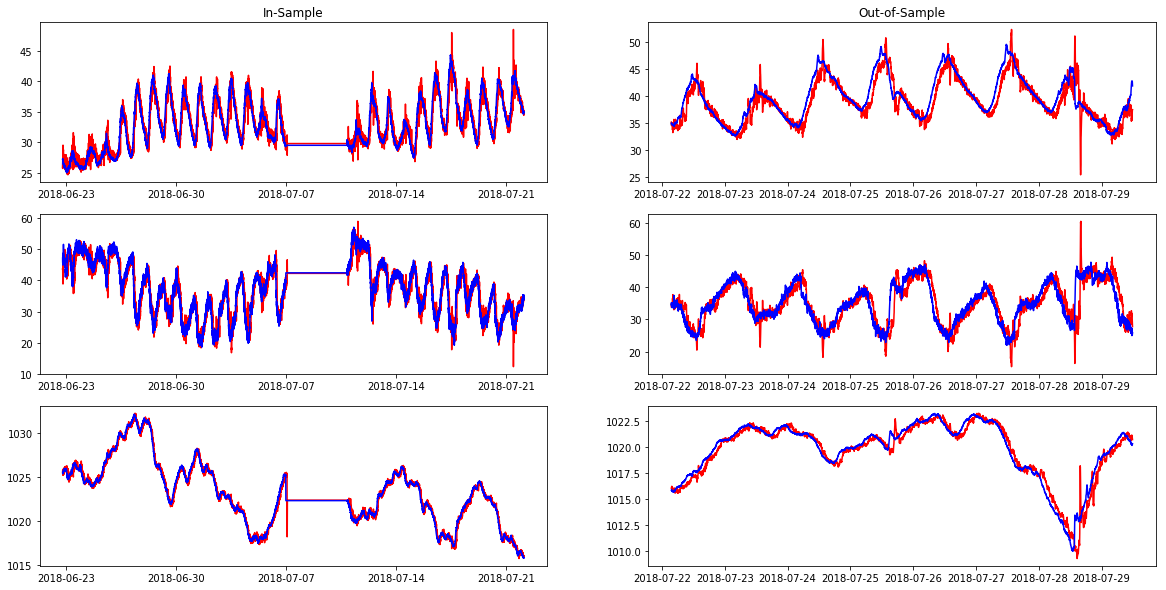

In [10]:
plt.figure(1,figsize=(20,10))
plt.subplot(321)
plt.plot(training_result['temp'],'r-',training_data_target['temp'],'b-')
plt.title('In-Sample')
plt.subplot(323)
plt.plot(training_result['humidity'],'r-',training_data_target['humidity'],'b-')
plt.subplot(325)
plt.plot(training_result['pressure'],'r-',training_data_target['pressure'],'b-')
plt.subplot(322)
plt.plot(testing_result['temp'],'r-',testing_data_target['temp'],'b-')
plt.title('Out-of-Sample')
plt.subplot(324)
plt.plot(testing_result['humidity'],'r-',testing_data_target['humidity'],'b-')
plt.subplot(326)
plt.plot(testing_result['pressure'],'r-',testing_data_target['pressure'],'b-')

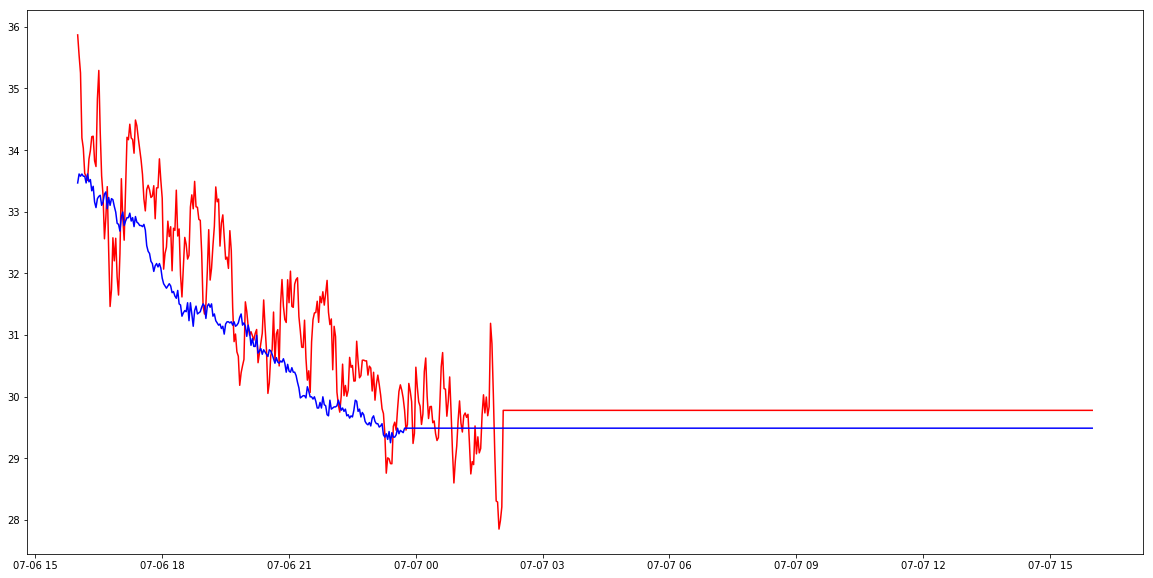

In [11]:
plt.figure(1,figsize=(20,10))
date = y_index[10000]
plt.plot(training_result['temp'][date:date+timedelta(days=1)],'r-',training_data_target['temp'][date:date+timedelta(days=1)],'b-')

## Diagnostic Plots

https://data.library.virginia.edu/diagnostic-plots/

https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

In [27]:
model_fitted_y = insample_stats.fittedvalues

# model residuals
model_residuals = insample_stats.resid

# normalized residuals
model_norm_residuals = insample_stats.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = insample_stats.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = insample_stats.get_influence().cooks_distance[0]

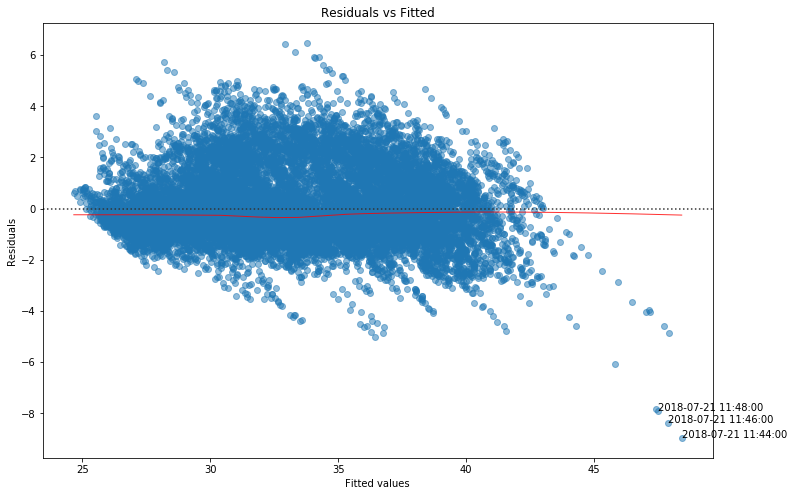

In [28]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sn.residplot(model_fitted_y, training_data_target['temp'],  
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

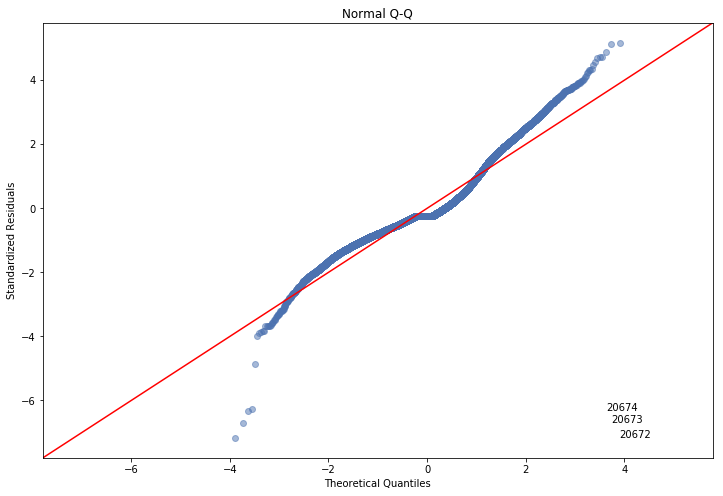

In [30]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

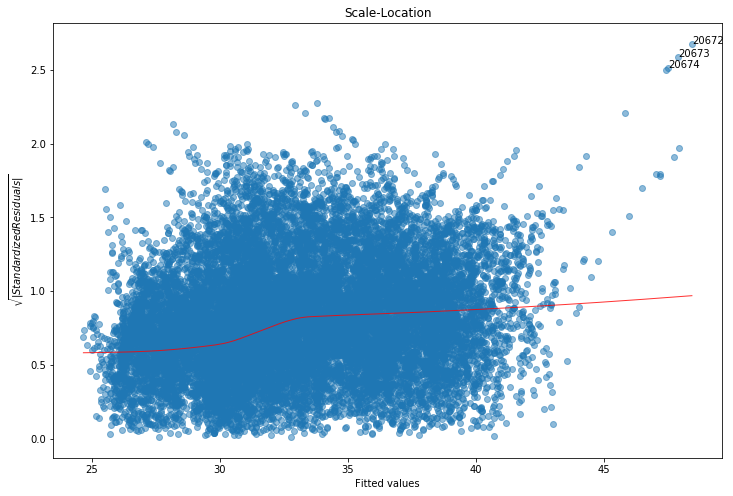

In [32]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sn.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

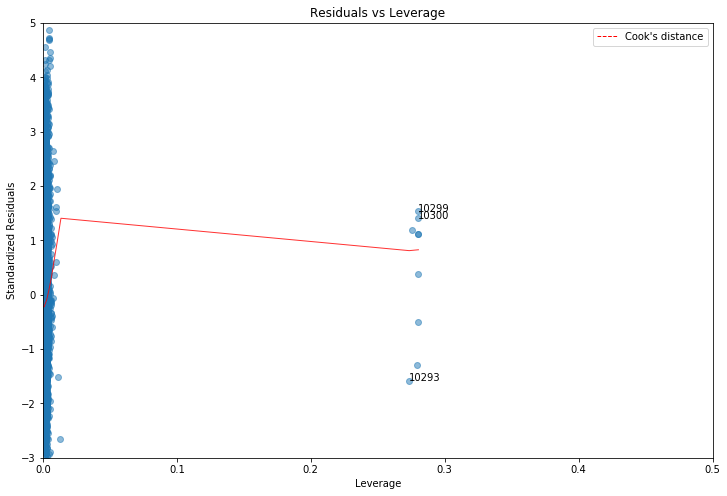

In [36]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sn.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.50)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(insample_stats.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');